# from here

In [ ]:
!pip install --quiet imutils
!pip install --quiet torchsummary
!pip install --quiet timm
#!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
#!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
#!pip install -q torch-geometric

     |████████████████████████████████| 296kB 4.2MB/s 


In [ ]:
from torchsummary import summary
import pandas as pd
import random
import imutils
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
from PIL import Image
from math import *
import time
import timm

In [ ]:
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.8.1+cu101
cuda version: 10.1
cudnn version:7603


In [ ]:
#from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/MyDrive/IXIDB_csv/mra_axial.csv')
df = df.loc[:,['location','x','y','fn','order']]
#df_train,df_valid = train_test_split(df,test_size=0.2)
df_train = df[:1260]
df_valid = df[1260:]

In [ ]:
mean_points = np.zeros((3,2))
for i in range(3):
  mean_points[i] = df_train[df_train['order']==i+1].mean()['x'],df_train[df_train['order']==(i+1)].mean()['y']
mean_points

array([[103.79285714, 145.2047619 ],
       [152.80952381, 143.84761905],
       [128.36666667, 129.18333333]])

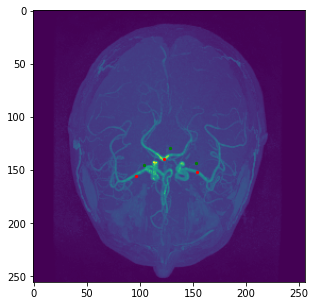

In [ ]:
landmarks = []
for i in range(3,6):
  landmarks.append([df_train.loc[i]['x'], df_train.loc[i]['y']])
landmarks = np.array(landmarks)

plt.figure(figsize=(5,5))
plt.imshow(cv2.imread('/content/drive/MyDrive/IXIDB_axial_png'+'/'+df_train.loc[3]['fn'],0))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.scatter(mean_points[:,0],mean_points[:,1],s=5,c='g')
plt.show()

In [ ]:
landmarks

array([[ 96, 156],
       [154, 152],
       [123, 140]])

In [ ]:
crop_w = (256-96)/2
crop_h =(256-96)/2

In [ ]:
landmarks = landmarks - np.array([[crop_w,crop_h]])
#temp = landmarks[0].copy()
#landmarks[0]=landmarks[1]
#landmarks[1]=temp
landmarks

array([[16., 76.],
       [74., 72.],
       [43., 60.]])

In [ ]:
landmarks[:,0] = 96-landmarks[:,0]
temp = landmarks[0].copy()
landmarks[0] = landmarks[1]
landmarks[1]=temp
landmarks

array([[22., 72.],
       [80., 76.],
       [53., 60.]])

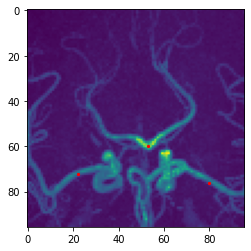

In [ ]:
#plt.figure(figsize=(5,5))
img = np.fliplr(cv2.imread('/content/drive/MyDrive/IXIDB_axial_png'+'/'+df_train.loc[3]['fn'],0)[80:176,80:176])
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.show()

In [ ]:
landmarks /=96

In [ ]:
transform = [
             [cos(radians(20)),-sin(radians(20))],
             [sin(radians(20)), cos(radians(20))]
]
landmarks-=0.5
landmarks = np.matmul(landmarks,transform)+0.5
landmarks

array([[0.33100495, 0.82755361],
       [0.91298675, 0.6600703 ],
       [0.59169484, 0.59964803]])

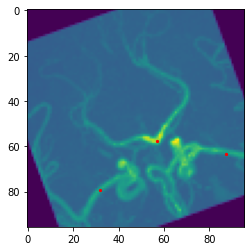

In [ ]:
#plt.figure(figsize=(5,5))
landmarks = landmarks*96
img = np.array(Image.fromarray(img))
img = imutils.rotate(img,20)
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
plt.show()

- flip 빼도 결과가 잘 나옴...근데 flip을 적용해야 할 수도 있을텐데...ㅠㅠ
- 일단 hrnet에서 사용한 transform 참고해봐야 할 듯하고 일단 gnn적용 어떻게 할지 고민하기

In [ ]:
class Transforms_train():
    def __init__(self):
        pass

    def flip(self,image,landmarks):
      h,w = np.array(image).shape
      if random.random()>0.5:
        image = TF.hflip(image)
        landmarks[:,0] = 1-landmarks[:,0]-1/w
        temp = landmarks[0].clone() #넘파이는 copy, tensor는 clone
        landmarks[0]=landmarks[1]
        landmarks[1]=temp
        
      '''if random.random()>0.5:
        landmarks[:,1] = image_height -landmarks[:,1] -1
        image = TF.vflip(image)'''

      return image ,landmarks

      
    def cropimg(self,image,landmarks):
      image_height, image_width = np.array(image).shape
      
      crop_height, crop_width = int(round(image_height/2.)), int(round(image_width/2.))
      crop_top = int(round((image_height - crop_height) / 2.))
      crop_left = int(round((image_width - crop_width) / 2.))

      image = TF.crop(image, crop_top, crop_left, crop_height, crop_width)
      
      img_shape = np.array(image).shape
      landmarks = torch.tensor(landmarks) - torch.tensor([[crop_left, crop_top]])
      landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])

      return image,landmarks

    def rotate(self, image, landmarks,angle):
      angle = random.uniform(-angle, +angle)
      scale = random.uniform(0.75,1.25)
      x_t, y_t = random.randint(-5,5), random.randint(-5,5)
      image_height, image_width = np.array(image).shape

      transformation_matrix = torch.tensor([
      [+cos(radians(angle)), -sin(radians(angle))], 
      [+sin(radians(angle)), +cos(radians(angle))]
      ])

      image = imutils.rotate(np.array(image), angle,None,scale)
      #image = imutils.translate(np.array(image),x_t,y_t)

      landmarks = landmarks - 0.5
      new_landmarks = np.matmul(landmarks, transformation_matrix)
      #new_landmarks = new_landmarks+np.array([[x_t/image_width, y_t/image_height]])
      new_landmarks = new_landmarks*scale

      new_landmarks = new_landmarks + 0.5

      return Image.fromarray(image), new_landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.cropimg(image, landmarks)
        image, landmarks = self.flip(image, landmarks)
        image, landmarks = self.rotate(image, landmarks,angle=20)
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class Transforms_valid():
    def __init__(self):
        pass
    def cropimg(self,image,landmarks):
      image_height,image_width = np.array(image).shape
      
      crop_height, crop_width = int(round(image_height/2.)), int(round(image_width/2.))
      crop_top = int(round((image_height - crop_height) / 2.))
      crop_left = int(round((image_width - crop_width) / 2.))

      image = TF.crop(image, crop_top, crop_left, crop_height, crop_width)
      
      img_shape = np.array(image).shape
      landmarks = torch.tensor(landmarks) - torch.tensor([[crop_left, crop_top]])
      landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])

      return image,landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image,landmarks = self.cropimg(image, landmarks)   
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class axialDataset(torch.utils.data.Dataset):

    def __init__(self,df, transform=None,train=False):

        self.transform = transform
        self.train =train
        
        if train :
          self.image_filenames = []
          self.landmarks = []
          self.init_landmarks = []
          self.df_train = df
          self.root_dir = '/content/drive/MyDrive/IXIDB_axial_png' # 사진폴더연결
          for filename in sorted(list(set(df_train['fn'].tolist()))):
              self.image_filenames.append(os.path.join(self.root_dir, filename))
              landmark = []

              for i,j in zip(df_train[df_train['fn']==filename]['x'],df_train[df_train['fn']==filename]['y']):
                  x_coordinate = i
                  y_coordinate = j
                  landmark.append([x_coordinate, y_coordinate])
              self.landmarks.append(landmark)
          self.landmarks = np.array(self.landmarks).astype('float32')
          self.init_landmarks = 2.0*((np.mean(self.landmarks,axis=0)-np.array([[64,64]]))/128)-1.0

        else :
          self.image_filenames = []
          self.landmarks = []
          self.df_valid = df
          self.root_dir = '/content/drive/MyDrive/IXIDB_axial_png' #사진폴더
          for filename in sorted(list(set(df_valid['fn'].tolist()))):
              self.image_filenames.append(os.path.join(self.root_dir, filename))
              landmark = []

              for i,j in zip(df_valid[df_valid['fn']==filename]['x'],df_valid[df_valid['fn']==filename]['y']):
                  x_coordinate = i
                  y_coordinate = j
                  landmark.append([x_coordinate, y_coordinate])
              self.landmarks.append(landmark)

          self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        if self.train :
          init_land = torch.Tensor(self.init_landmarks)
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks)

        landmarks = landmarks - 0.5

        if self.train : 
          return image, landmarks, init_land
        else:
          return image, landmarks

In [ ]:
dataset_train = axialDataset(df_train,Transforms_train(),True)
dataset_valid = axialDataset(df_valid,Transforms_valid(),False)

In [ ]:
len(dataset_train),len(dataset_valid)

(420, 37)

tensor([[-0.3782,  0.2688],
        [ 0.3876,  0.2476],
        [ 0.0057,  0.0185]])


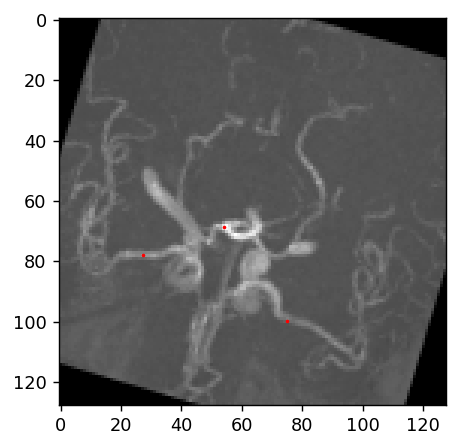

In [ ]:
image, points,init_land_ = dataset_train[4]
print(init_land_)
points = (points+0.5)*128
plt.figure(dpi=128)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.scatter(points[:,0], points[:,1], s=1,c='r')

# 나오는 결과 포인트*128+128하면 원래값으로 돌아옴!

In [ ]:
batch_size=8
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True, num_workers=2,)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size, shuffle=False, num_workers=2)
images, landmarks,init_land = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)
print(init_land.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 3, 2])
torch.Size([8, 3, 2])


In [ ]:
img,land = next(iter(valid_loader))

print(img.shape)
print(land.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 3, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=6):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
# network는 쿠다에 있고, Network는 그냥 cpu에 있다고 해야되나? 그런데 파라미터 로드는 가능함
Network().load_state_dict(torch.load('/content/drive/MyDrive/IXIDB_axial_model_save/face_landmarks.pth'))

<All keys matched successfully>

# from here

In [ ]:
class Net(nn.Module):
  def __init__(self,network):
    super(Net,self).__init__()
    self.features0 = nn.Sequential(
        network.model.conv1,
        network.model.bn1,
        network.model.relu,
        network.model.maxpool
    )
    self.features1 = nn.Sequential(network.model.layer1)
    self.features2 = nn.Sequential(network.model.layer2)
    self.features3 = nn.Sequential(network.model.layer3)
    self.features4 = nn.Sequential(network.model.layer4)
  
  def forward(self, x):
    x= self.features0(x)
    layer1 = self.features1(x)
    layer2 = self.features2(layer1)
    layer3 = self.features3(layer2)
    layer4 = self.features4(layer3)

    a = torch.cat((F.interpolate(layer4,[8,8],mode='bilinear',align_corners=False),layer3),dim=1)
    b= torch.cat((F.interpolate(a,[16,16],mode='bilinear',align_corners=False),layer2),dim=1)
    c = torch.cat((F.interpolate(b,[32,32],mode='bilinear',align_corners=False),layer1),dim=1)
    d = F.interpolate(c,[128,128],mode='bilinear',align_corners=False)

    return d

def FE(d,landmarks,batch_size):
  visual_feature = F.grid_sample(d,landmarks.unsqueeze(2),mode='bilinear',padding_mode='zeros',align_corners=False)[:,:,:,0]
  visual_feature = visual_feature.permute(0,2,1)
  init_landmark = landmarks[:,None,:,:]-landmarks[:,:,None,:]
  shape_feature = init_landmark.reshape(batch_size, landmarks.shape[1],-1)

  return torch.cat([visual_feature,shape_feature],-1)


class GIN(nn.Module):
  def __init__(self,in_ch,out_ch,num_landmark=3):
    super(GIN, self).__init__()
    self.adj = torch.nn.Parameter((torch.ones((num_landmark, num_landmark), requires_grad=True) / num_landmark), requires_grad=True)
    self.linear1 = nn.Linear(in_ch,in_ch)
    self.relu1 = nn.LeakyReLU(inplace=True)
    self.linear2 = nn.Linear(in_ch, out_ch)

  def forward(self, node_feat):
    nd = node_feat
    message = torch.matmul(self.adj, nd)+nd
    x = self.linear1(message)
    x= self.relu1(x)
    x= self.linear2(x)
    return x


class GCN(nn.Module):
  def __init__(self, in_ch=966, out_ch=9):
    super(GCN,self).__init__()
    self.net = Net(Network())    
    self.gin1 = GIN(in_ch,in_ch)
    self.gin2 = GIN(in_ch,int(in_ch/2))
    self.gin3 = GIN(int(in_ch/2),int(in_ch/2))
    self.lin = nn.Linear(in_ch+int(in_ch/2)+int(in_ch/2), out_ch)

  def forward(self, image, init_land):
    bs = image.shape[0]
    prediction = self.net(image)
    predictions = FE(prediction, init_land, bs)
    layer0=self.gin1(predictions)
    layer1=self.gin2(layer0)
    layer2=self.gin3(layer1)
    layer0_sum = torch.sum(layer0, dim=1)
    layer1_sum = torch.sum(layer1, dim=1)
    layer2_sum = torch.sum(layer2, dim=1)
    cat = torch.cat([layer0_sum, layer1_sum, layer2_sum], -1)
    out = self.lin(cat)
    return out, prediction

class GIN_local(nn.Module):
  def __init__(self, steps=3, h_dim=966, num_landmarks=3):
    super(GIN_local,self).__init__()
    self.steps = steps
    for step in range(self.steps):
      if step == 0:
          self.gnns = nn.ModuleList(
              [GIN(h_dim, 2)])
      else:
          self.gnns.append(GIN(h_dim, 2))
    
  def forward(self,d,x):
    bs = x.shape[0]
    for step in range(self.steps):
      shift=self.gnns[step](FE(d, x, bs))
      updated_landmarks = x + shift
      y = updated_landmarks
    return y  

In [ ]:
def make_perspective_transform(global_t, init_land):
  batch_size = global_t.shape[0]
  global_t = global_t.view(batch_size,3,3)
  m = nn.ConstantPad1d((0, 1),1)
  init_land_1 = m(init_land)
  init_land_2 = init_land_1.permute(0,2,1)
  p_land = torch.matmul(global_t,init_land_2.cuda()) # [ rx ry r]t
  p_land = p_land.permute(0,2,1)
  pt_land = torch.zeros((batch_size,3,2)).cuda()
  pt_land[:, :, 0] = p_land[:, :, 0] / p_land[:, :, 2]
  pt_land[:, :, 1] = p_land[:, :, 1] / p_land[:, :, 2]
  return pt_land

In [ ]:
#gcn_in_ch = 966
gcn = GCN().cuda()
gin_local = GIN_local().cuda()

In [ ]:
a,b=gcn(images.cuda(),init_land.cuda())

In [ ]:
a.shape, b.shape

(torch.Size([8, 9]), torch.Size([8, 960, 128, 128]))

In [ ]:
pt_land =make_perspective_transform(a,init_land)
gin_local(b,pt_land).shape

torch.Size([8, 3, 2])

In [ ]:
torch.autograd.set_detect_anomaly(True)

criterion = nn.MSELoss()

optimizer_global = optim.AdamW(gcn.parameters(), lr=3e-4,weight_decay=0.00001)
optimizer_local = optim.AdamW(gin_local.parameters(),lr=3e-4,weight_decay=0.00001)

scheduler_global = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_global, patience=3,threshold=e-10,factor=0.9)
scheduler_local = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_local, patience=3,threshold=e-10,factor=0.9)

loss_min = np.inf
num_epochs = 200

In [ ]:
#Helper function
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

Valid Steps: 5/5  Loss: 0.0768 
--------------------------------------------------
Epoch: 1  Train Loss: 1.6071  Valid Loss: 0.0768
--------------------------------------------------


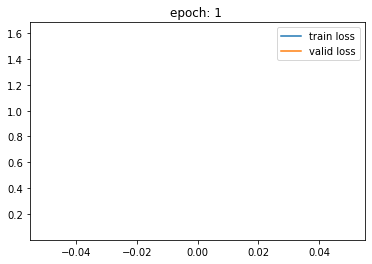


Minimum Validation Loss of 0.0768 at epoch 1/200
Model Saved

Valid Steps: 5/5  Loss: 0.0418 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0393  Valid Loss: 0.0418
--------------------------------------------------


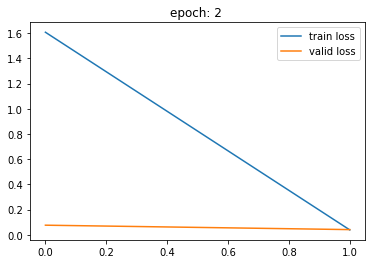


Minimum Validation Loss of 0.0418 at epoch 2/200
Model Saved

Valid Steps: 5/5  Loss: 0.0760 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0221  Valid Loss: 0.0760
--------------------------------------------------


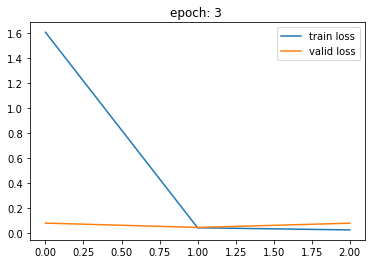

Train Steps: 52/53  Loss: 0.0203 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1uavfpkv'


Valid Steps: 5/5  Loss: 0.0306 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0202  Valid Loss: 0.0306
--------------------------------------------------


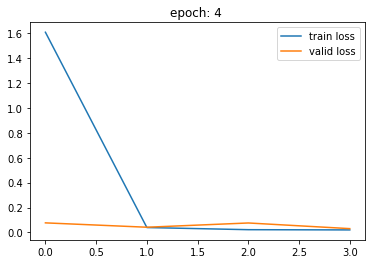


Minimum Validation Loss of 0.0306 at epoch 4/200
Model Saved

Valid Steps: 5/5  Loss: 0.0288 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0155  Valid Loss: 0.0288
--------------------------------------------------


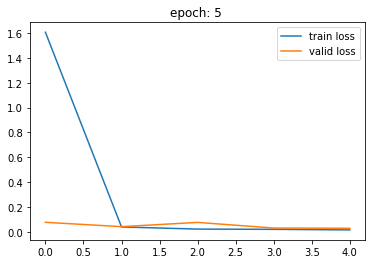


Minimum Validation Loss of 0.0288 at epoch 5/200
Model Saved

Valid Steps: 5/5  Loss: 0.0459 
--------------------------------------------------
Epoch: 6  Train Loss: 0.0155  Valid Loss: 0.0459
--------------------------------------------------


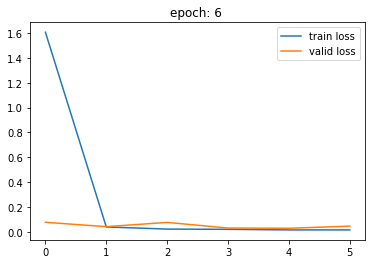

Valid Steps: 5/5  Loss: 0.0423 
--------------------------------------------------
Epoch: 7  Train Loss: 0.0142  Valid Loss: 0.0423
--------------------------------------------------


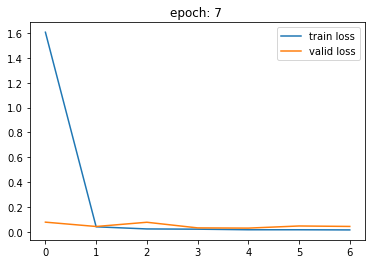

Valid Steps: 5/5  Loss: 0.0310 
--------------------------------------------------
Epoch: 8  Train Loss: 0.0132  Valid Loss: 0.0310
--------------------------------------------------


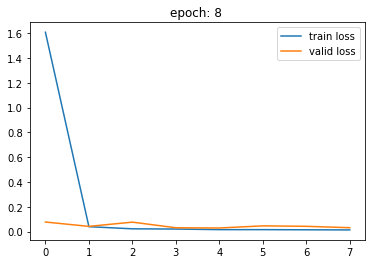

Valid Steps: 5/5  Loss: 0.0339 
--------------------------------------------------
Epoch: 9  Train Loss: 0.0121  Valid Loss: 0.0339
--------------------------------------------------


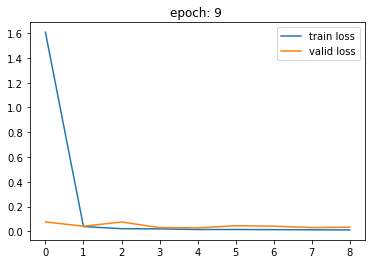

Valid Steps: 5/5  Loss: 0.0323 
--------------------------------------------------
Epoch: 10  Train Loss: 0.0109  Valid Loss: 0.0323
--------------------------------------------------


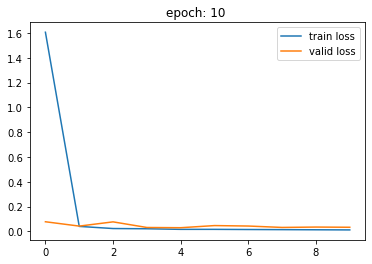

Train Steps: 40/53  Loss: 0.0096 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-6tbza5au'


Valid Steps: 5/5  Loss: 0.0315 
--------------------------------------------------
Epoch: 11  Train Loss: 0.0097  Valid Loss: 0.0315
--------------------------------------------------


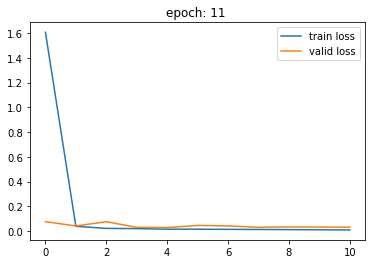

Valid Steps: 5/5  Loss: 0.0362 
--------------------------------------------------
Epoch: 12  Train Loss: 0.0083  Valid Loss: 0.0362
--------------------------------------------------


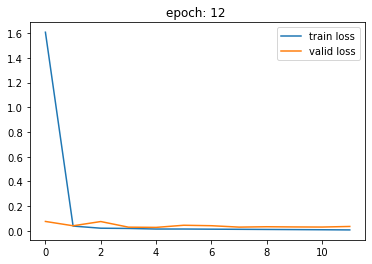

Valid Steps: 5/5  Loss: 0.0210 
--------------------------------------------------
Epoch: 13  Train Loss: 0.0092  Valid Loss: 0.0210
--------------------------------------------------


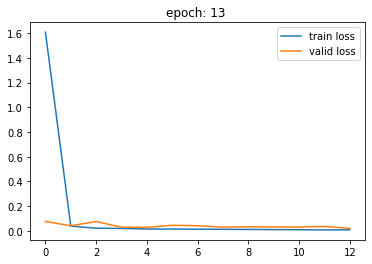


Minimum Validation Loss of 0.0210 at epoch 13/200
Model Saved

Valid Steps: 5/5  Loss: 0.0301 
--------------------------------------------------
Epoch: 14  Train Loss: 0.0081  Valid Loss: 0.0301
--------------------------------------------------


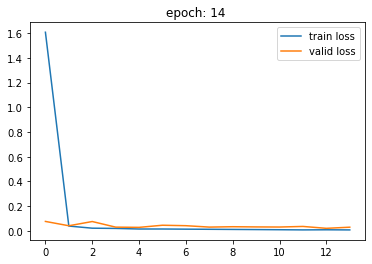

Valid Steps: 5/5  Loss: 0.0287 
--------------------------------------------------
Epoch: 15  Train Loss: 0.0084  Valid Loss: 0.0287
--------------------------------------------------


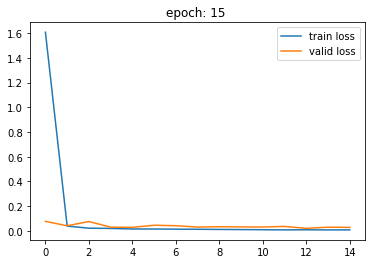

Valid Steps: 5/5  Loss: 0.0253 
--------------------------------------------------
Epoch: 16  Train Loss: 0.0081  Valid Loss: 0.0253
--------------------------------------------------


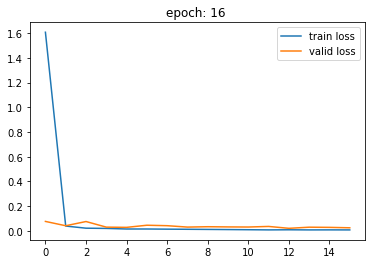

Valid Steps: 5/5  Loss: 0.0215 
--------------------------------------------------
Epoch: 17  Train Loss: 0.0070  Valid Loss: 0.0215
--------------------------------------------------


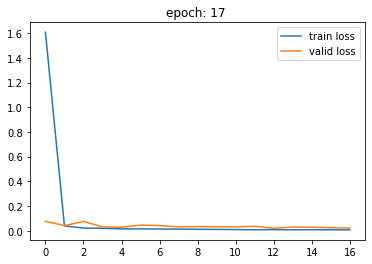

Valid Steps: 5/5  Loss: 0.0177 
--------------------------------------------------
Epoch: 18  Train Loss: 0.0063  Valid Loss: 0.0177
--------------------------------------------------


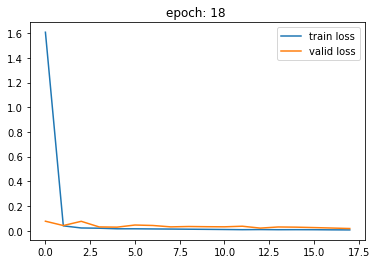


Minimum Validation Loss of 0.0177 at epoch 18/200
Model Saved

Valid Steps: 5/5  Loss: 0.0213 
--------------------------------------------------
Epoch: 19  Train Loss: 0.0071  Valid Loss: 0.0213
--------------------------------------------------


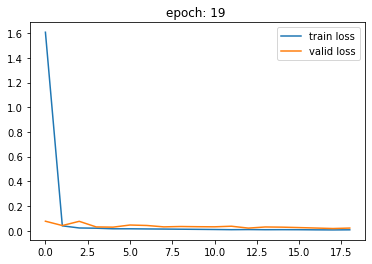

Valid Steps: 5/5  Loss: 0.0224 
--------------------------------------------------
Epoch: 20  Train Loss: 0.0062  Valid Loss: 0.0224
--------------------------------------------------


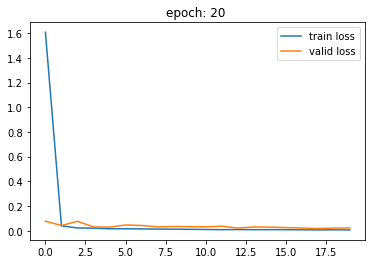

Valid Steps: 5/5  Loss: 0.0206 
--------------------------------------------------
Epoch: 21  Train Loss: 0.0068  Valid Loss: 0.0206
--------------------------------------------------


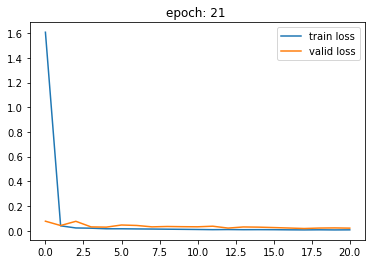

Valid Steps: 5/5  Loss: 0.0181 
--------------------------------------------------
Epoch: 22  Train Loss: 0.0061  Valid Loss: 0.0181
--------------------------------------------------


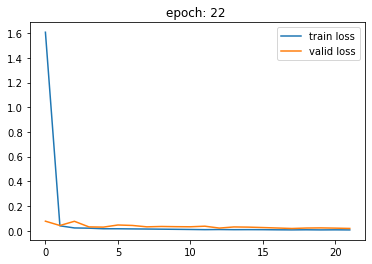

Valid Steps: 5/5  Loss: 0.0162 
--------------------------------------------------
Epoch: 23  Train Loss: 0.0067  Valid Loss: 0.0162
--------------------------------------------------


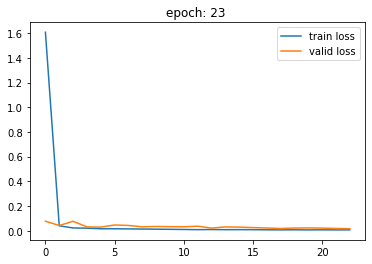


Minimum Validation Loss of 0.0162 at epoch 23/200
Model Saved

Train Steps: 8/53  Loss: 0.0052 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-7yf1sfou'


Train Steps: 11/53  Loss: 0.0053 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-cm4fbknn'


Valid Steps: 5/5  Loss: 0.0279 
--------------------------------------------------
Epoch: 24  Train Loss: 0.0061  Valid Loss: 0.0279
--------------------------------------------------


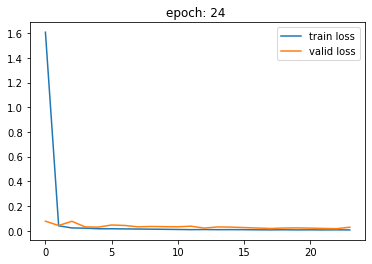

Valid Steps: 5/5  Loss: 0.0119 
--------------------------------------------------
Epoch: 25  Train Loss: 0.0057  Valid Loss: 0.0119
--------------------------------------------------


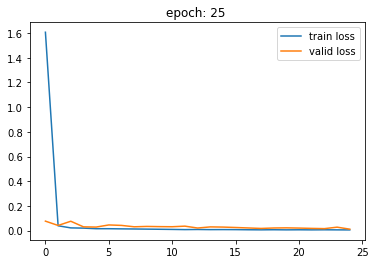


Minimum Validation Loss of 0.0119 at epoch 25/200
Model Saved

Valid Steps: 5/5  Loss: 0.0158 
--------------------------------------------------
Epoch: 26  Train Loss: 0.0049  Valid Loss: 0.0158
--------------------------------------------------


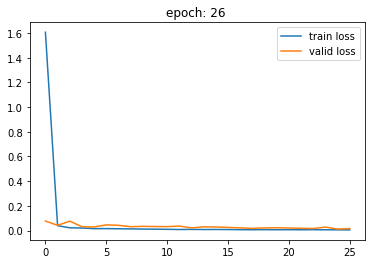

Valid Steps: 5/5  Loss: 0.0131 
--------------------------------------------------
Epoch: 27  Train Loss: 0.0054  Valid Loss: 0.0131
--------------------------------------------------


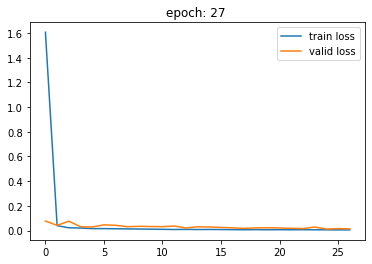

Valid Steps: 5/5  Loss: 0.0134 
--------------------------------------------------
Epoch: 28  Train Loss: 0.0052  Valid Loss: 0.0134
--------------------------------------------------


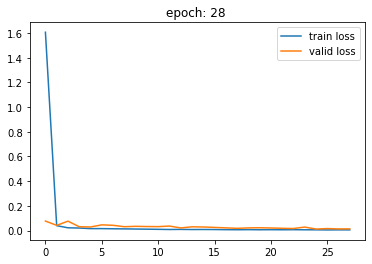

Valid Steps: 5/5  Loss: 0.0147 
--------------------------------------------------
Epoch: 29  Train Loss: 0.0046  Valid Loss: 0.0147
--------------------------------------------------


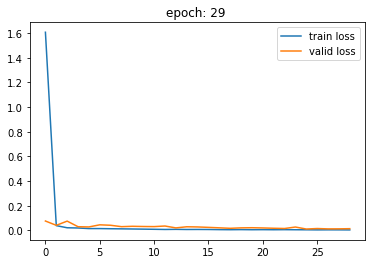

Valid Steps: 5/5  Loss: 0.0099 
--------------------------------------------------
Epoch: 30  Train Loss: 0.0052  Valid Loss: 0.0099
--------------------------------------------------


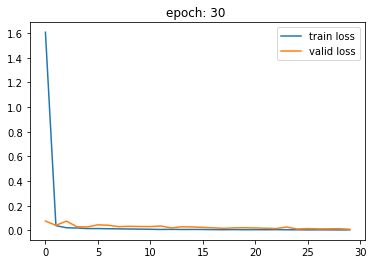


Minimum Validation Loss of 0.0099 at epoch 30/200
Model Saved

Valid Steps: 5/5  Loss: 0.0105 
--------------------------------------------------
Epoch: 31  Train Loss: 0.0052  Valid Loss: 0.0105
--------------------------------------------------


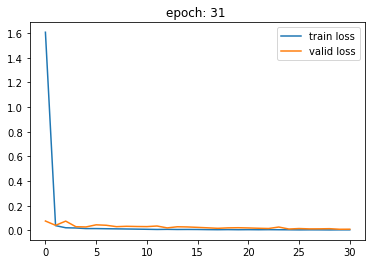

Valid Steps: 5/5  Loss: 0.0226 
--------------------------------------------------
Epoch: 32  Train Loss: 0.0045  Valid Loss: 0.0226
--------------------------------------------------


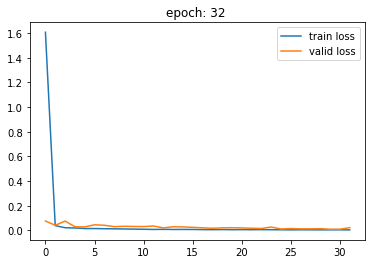

Valid Steps: 5/5  Loss: 0.0109 
--------------------------------------------------
Epoch: 33  Train Loss: 0.0054  Valid Loss: 0.0109
--------------------------------------------------


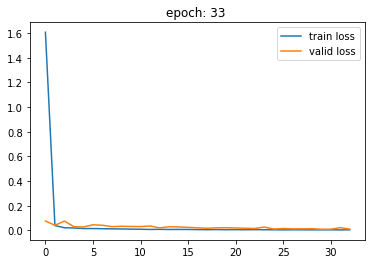

Valid Steps: 5/5  Loss: 0.0118 
--------------------------------------------------
Epoch: 34  Train Loss: 0.0047  Valid Loss: 0.0118
--------------------------------------------------


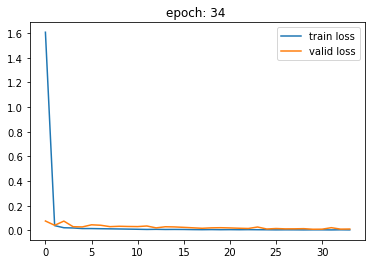

Valid Steps: 5/5  Loss: 0.0113 
--------------------------------------------------
Epoch: 35  Train Loss: 0.0048  Valid Loss: 0.0113
--------------------------------------------------


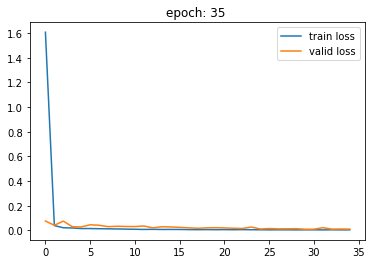

Valid Steps: 5/5  Loss: 0.0073 
--------------------------------------------------
Epoch: 36  Train Loss: 0.0052  Valid Loss: 0.0073
--------------------------------------------------


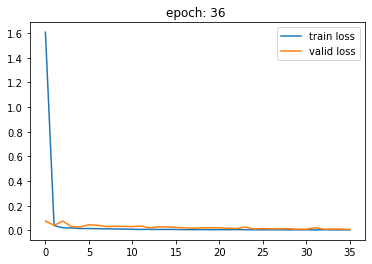


Minimum Validation Loss of 0.0073 at epoch 36/200
Model Saved

Valid Steps: 5/5  Loss: 0.0161 
--------------------------------------------------
Epoch: 37  Train Loss: 0.0045  Valid Loss: 0.0161
--------------------------------------------------


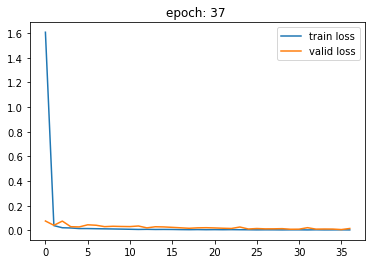

Valid Steps: 5/5  Loss: 0.0108 
--------------------------------------------------
Epoch: 38  Train Loss: 0.0039  Valid Loss: 0.0108
--------------------------------------------------


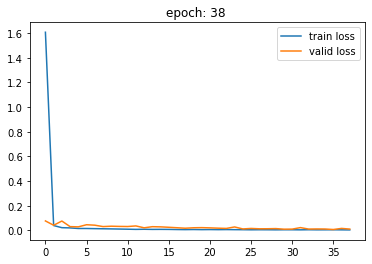

Valid Steps: 5/5  Loss: 0.0103 
--------------------------------------------------
Epoch: 39  Train Loss: 0.0042  Valid Loss: 0.0103
--------------------------------------------------


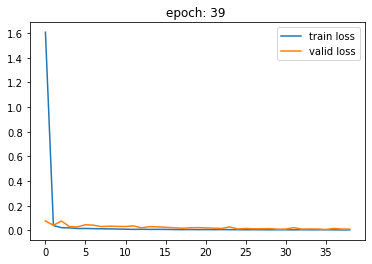

Valid Steps: 5/5  Loss: 0.0093 
--------------------------------------------------
Epoch: 40  Train Loss: 0.0037  Valid Loss: 0.0093
--------------------------------------------------


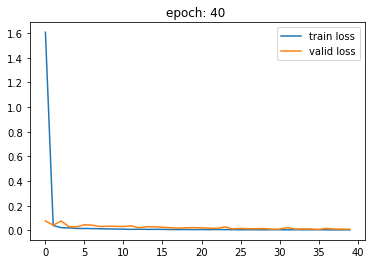

Valid Steps: 5/5  Loss: 0.0085 
--------------------------------------------------
Epoch: 41  Train Loss: 0.0043  Valid Loss: 0.0085
--------------------------------------------------


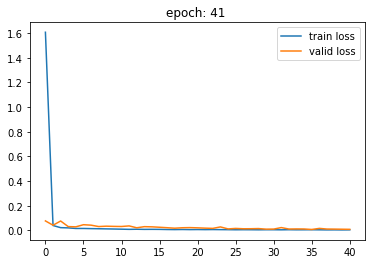

Valid Steps: 5/5  Loss: 0.0096 
--------------------------------------------------
Epoch: 42  Train Loss: 0.0042  Valid Loss: 0.0096
--------------------------------------------------


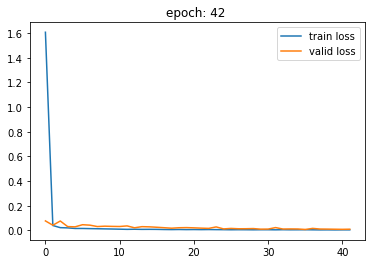

Valid Steps: 5/5  Loss: 0.0084 
--------------------------------------------------
Epoch: 43  Train Loss: 0.0043  Valid Loss: 0.0084
--------------------------------------------------


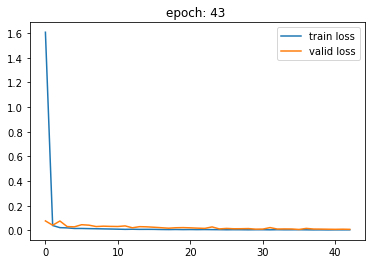

Valid Steps: 5/5  Loss: 0.0066 
--------------------------------------------------
Epoch: 44  Train Loss: 0.0042  Valid Loss: 0.0066
--------------------------------------------------


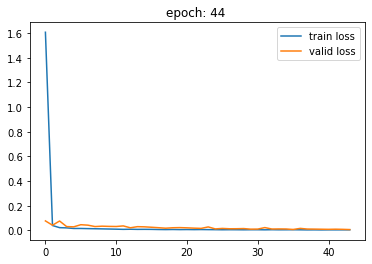


Minimum Validation Loss of 0.0066 at epoch 44/200
Model Saved

Valid Steps: 5/5  Loss: 0.0054 
--------------------------------------------------
Epoch: 45  Train Loss: 0.0035  Valid Loss: 0.0054
--------------------------------------------------


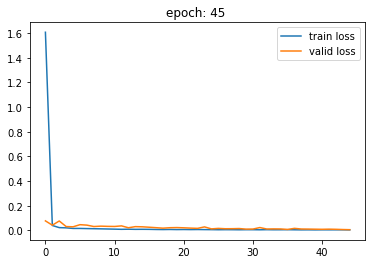


Minimum Validation Loss of 0.0054 at epoch 45/200
Model Saved

Valid Steps: 5/5  Loss: 0.0048 
--------------------------------------------------
Epoch: 46  Train Loss: 0.0034  Valid Loss: 0.0048
--------------------------------------------------


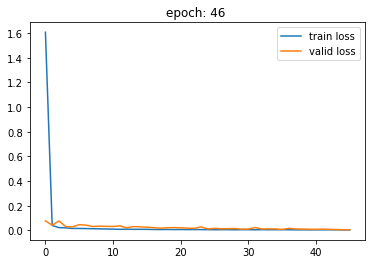


Minimum Validation Loss of 0.0048 at epoch 46/200
Model Saved

Valid Steps: 5/5  Loss: 0.0060 
--------------------------------------------------
Epoch: 47  Train Loss: 0.0037  Valid Loss: 0.0060
--------------------------------------------------


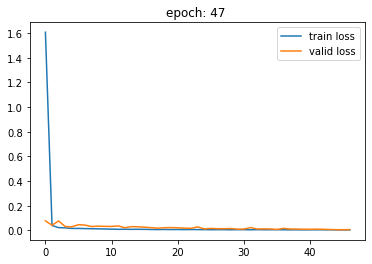

Valid Steps: 5/5  Loss: 0.0087 
--------------------------------------------------
Epoch: 48  Train Loss: 0.0037  Valid Loss: 0.0087
--------------------------------------------------


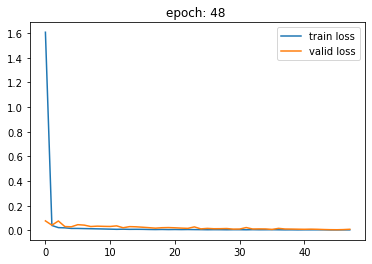

Valid Steps: 5/5  Loss: 0.0077 
--------------------------------------------------
Epoch: 49  Train Loss: 0.0033  Valid Loss: 0.0077
--------------------------------------------------


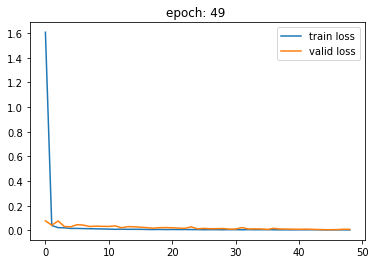

Valid Steps: 5/5  Loss: 0.0103 
--------------------------------------------------
Epoch: 50  Train Loss: 0.0034  Valid Loss: 0.0103
--------------------------------------------------


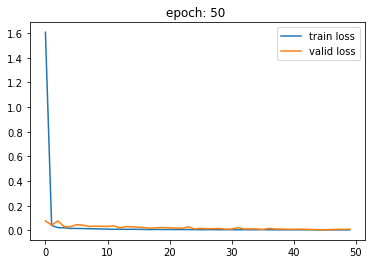

Valid Steps: 5/5  Loss: 0.0061 
--------------------------------------------------
Epoch: 51  Train Loss: 0.0034  Valid Loss: 0.0061
--------------------------------------------------


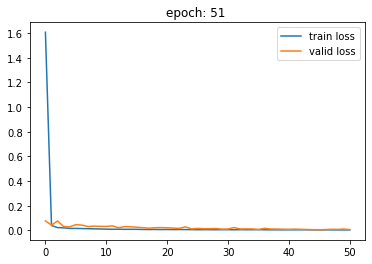

Valid Steps: 5/5  Loss: 0.0078 
--------------------------------------------------
Epoch: 52  Train Loss: 0.0032  Valid Loss: 0.0078
--------------------------------------------------


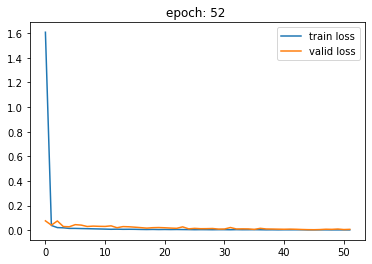

Valid Steps: 5/5  Loss: 0.0070 
--------------------------------------------------
Epoch: 53  Train Loss: 0.0033  Valid Loss: 0.0070
--------------------------------------------------


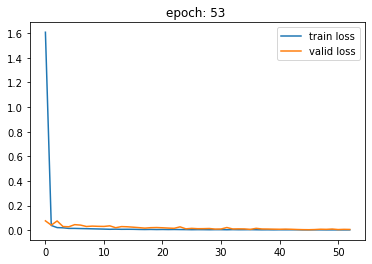

Valid Steps: 5/5  Loss: 0.0069 
--------------------------------------------------
Epoch: 54  Train Loss: 0.0033  Valid Loss: 0.0069
--------------------------------------------------


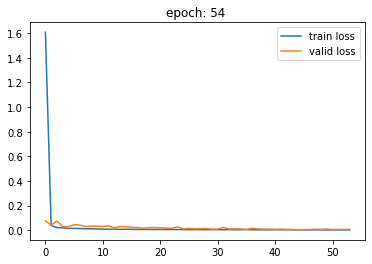

Valid Steps: 5/5  Loss: 0.0092 
--------------------------------------------------
Epoch: 55  Train Loss: 0.0042  Valid Loss: 0.0092
--------------------------------------------------


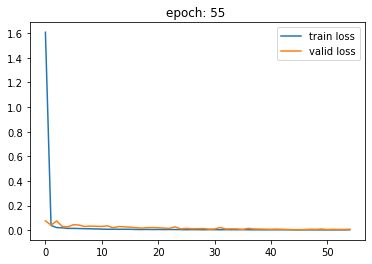

Valid Steps: 5/5  Loss: 0.0108 
--------------------------------------------------
Epoch: 56  Train Loss: 0.0036  Valid Loss: 0.0108
--------------------------------------------------


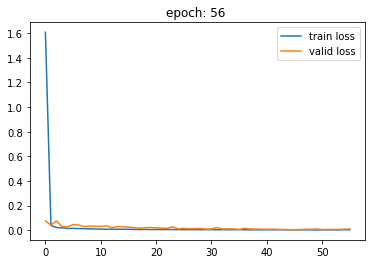

Train Steps: 38/53  Loss: 0.0035 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-i4jbn_9b'


Valid Steps: 5/5  Loss: 0.0094 
--------------------------------------------------
Epoch: 57  Train Loss: 0.0034  Valid Loss: 0.0094
--------------------------------------------------


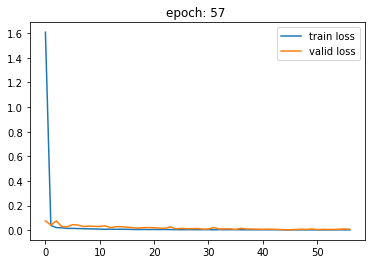

Valid Steps: 5/5  Loss: 0.0074 
--------------------------------------------------
Epoch: 58  Train Loss: 0.0035  Valid Loss: 0.0074
--------------------------------------------------


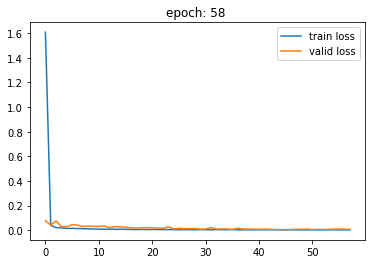

Valid Steps: 5/5  Loss: 0.0174 
--------------------------------------------------
Epoch: 59  Train Loss: 0.0030  Valid Loss: 0.0174
--------------------------------------------------


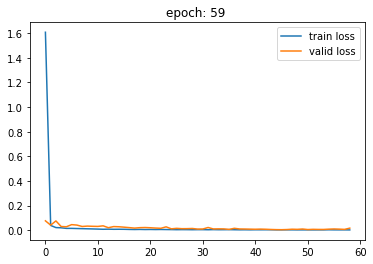

Train Steps: 49/53  Loss: 0.0038 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ugqx4hh9'


Valid Steps: 5/5  Loss: 0.0095 
--------------------------------------------------
Epoch: 60  Train Loss: 0.0038  Valid Loss: 0.0095
--------------------------------------------------


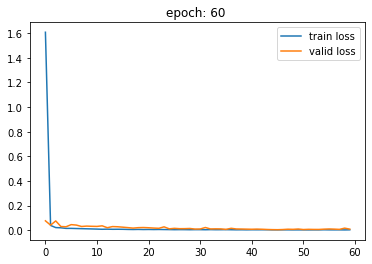

Valid Steps: 5/5  Loss: 0.0057 
--------------------------------------------------
Epoch: 61  Train Loss: 0.0031  Valid Loss: 0.0057
--------------------------------------------------


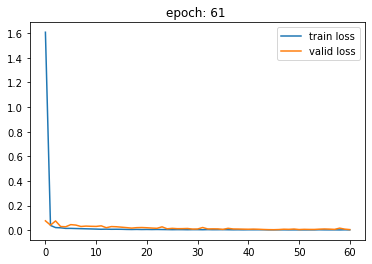

Valid Steps: 5/5  Loss: 0.0074 
--------------------------------------------------
Epoch: 62  Train Loss: 0.0026  Valid Loss: 0.0074
--------------------------------------------------


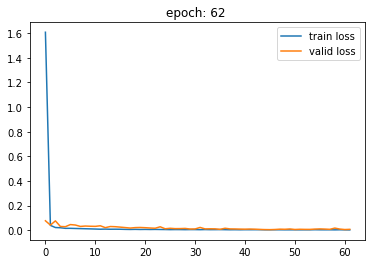

Valid Steps: 5/5  Loss: 0.0050 
--------------------------------------------------
Epoch: 63  Train Loss: 0.0029  Valid Loss: 0.0050
--------------------------------------------------


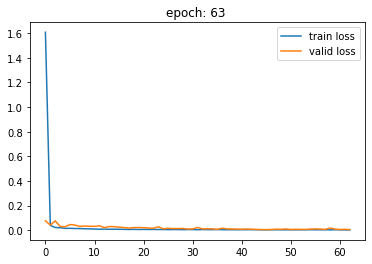

Train Steps: 41/53  Loss: 0.0029 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u19g5gbb'


Valid Steps: 5/5  Loss: 0.0106 
--------------------------------------------------
Epoch: 64  Train Loss: 0.0028  Valid Loss: 0.0106
--------------------------------------------------


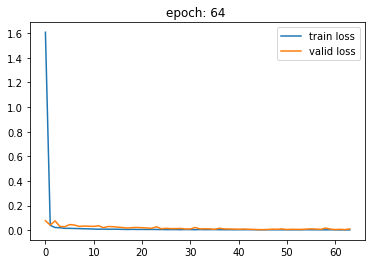

Valid Steps: 5/5  Loss: 0.0063 
--------------------------------------------------
Epoch: 65  Train Loss: 0.0031  Valid Loss: 0.0063
--------------------------------------------------


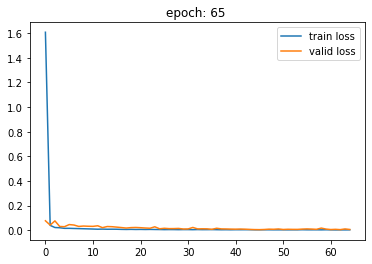

Valid Steps: 5/5  Loss: 0.0067 
--------------------------------------------------
Epoch: 66  Train Loss: 0.0029  Valid Loss: 0.0067
--------------------------------------------------


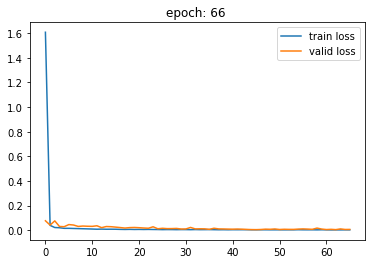

Valid Steps: 5/5  Loss: 0.0072 
--------------------------------------------------
Epoch: 67  Train Loss: 0.0030  Valid Loss: 0.0072
--------------------------------------------------


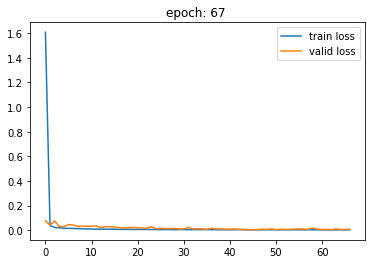

Valid Steps: 5/5  Loss: 0.0067 
--------------------------------------------------
Epoch: 68  Train Loss: 0.0027  Valid Loss: 0.0067
--------------------------------------------------


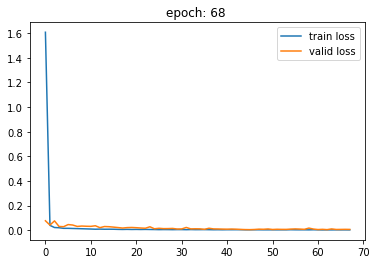

Valid Steps: 5/5  Loss: 0.0055 
--------------------------------------------------
Epoch: 69  Train Loss: 0.0029  Valid Loss: 0.0055
--------------------------------------------------


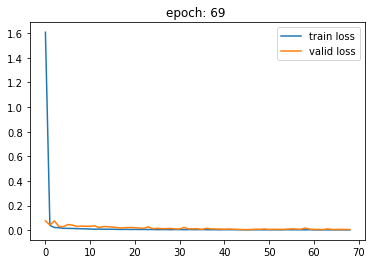

Valid Steps: 5/5  Loss: 0.0069 
--------------------------------------------------
Epoch: 70  Train Loss: 0.0029  Valid Loss: 0.0069
--------------------------------------------------


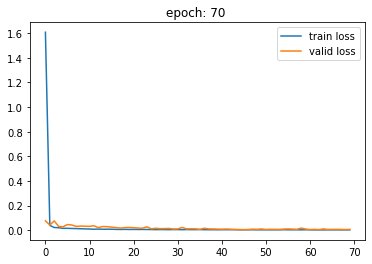

Valid Steps: 5/5  Loss: 0.0120 
--------------------------------------------------
Epoch: 71  Train Loss: 0.0027  Valid Loss: 0.0120
--------------------------------------------------


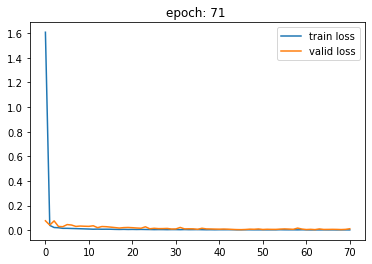

Valid Steps: 5/5  Loss: 0.0076 
--------------------------------------------------
Epoch: 72  Train Loss: 0.0025  Valid Loss: 0.0076
--------------------------------------------------


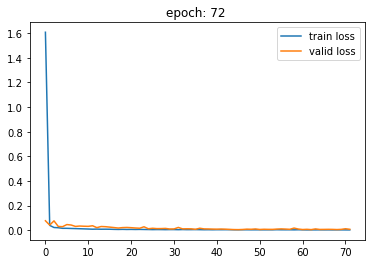

Valid Steps: 5/5  Loss: 0.0038 
--------------------------------------------------
Epoch: 73  Train Loss: 0.0028  Valid Loss: 0.0038
--------------------------------------------------


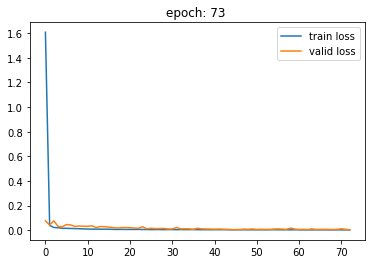


Minimum Validation Loss of 0.0038 at epoch 73/200
Model Saved

Valid Steps: 5/5  Loss: 0.0100 
--------------------------------------------------
Epoch: 74  Train Loss: 0.0027  Valid Loss: 0.0100
--------------------------------------------------


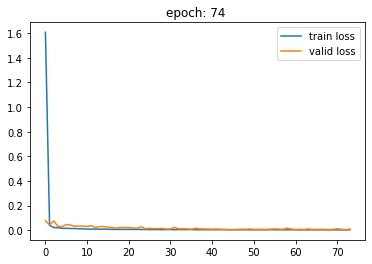

Valid Steps: 5/5  Loss: 0.0086 
--------------------------------------------------
Epoch: 75  Train Loss: 0.0028  Valid Loss: 0.0086
--------------------------------------------------


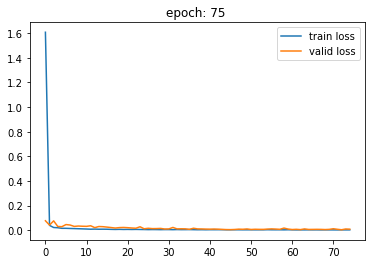

Valid Steps: 5/5  Loss: 0.0054 
--------------------------------------------------
Epoch: 76  Train Loss: 0.0029  Valid Loss: 0.0054
--------------------------------------------------


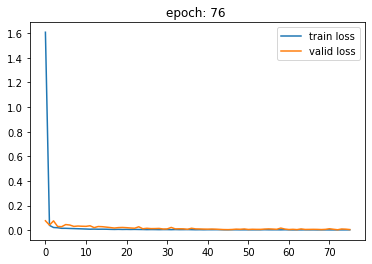

Train Steps: 38/53  Loss: 0.0031 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-f39ytexz'


Valid Steps: 5/5  Loss: 0.0054 
--------------------------------------------------
Epoch: 77  Train Loss: 0.0029  Valid Loss: 0.0054
--------------------------------------------------


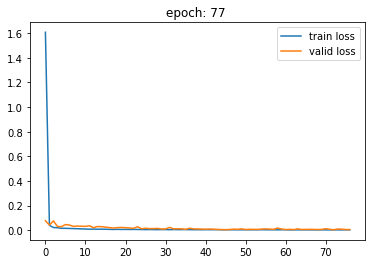

Valid Steps: 5/5  Loss: 0.0047 
--------------------------------------------------
Epoch: 78  Train Loss: 0.0022  Valid Loss: 0.0047
--------------------------------------------------


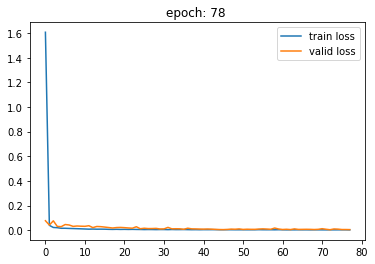

Valid Steps: 5/5  Loss: 0.0063 
--------------------------------------------------
Epoch: 79  Train Loss: 0.0026  Valid Loss: 0.0063
--------------------------------------------------


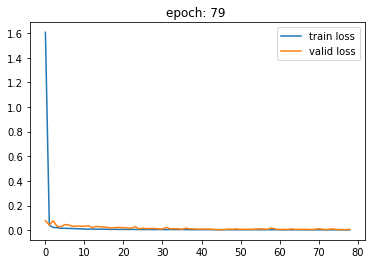

Valid Steps: 5/5  Loss: 0.0072 
--------------------------------------------------
Epoch: 80  Train Loss: 0.0027  Valid Loss: 0.0072
--------------------------------------------------


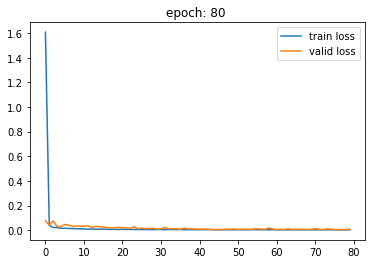

Valid Steps: 5/5  Loss: 0.0055 
--------------------------------------------------
Epoch: 81  Train Loss: 0.0025  Valid Loss: 0.0055
--------------------------------------------------


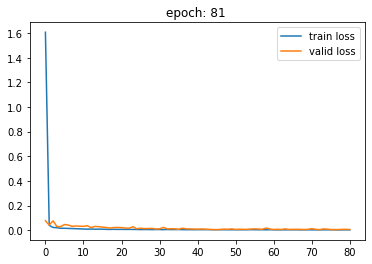

Valid Steps: 5/5  Loss: 0.0052 
--------------------------------------------------
Epoch: 82  Train Loss: 0.0025  Valid Loss: 0.0052
--------------------------------------------------


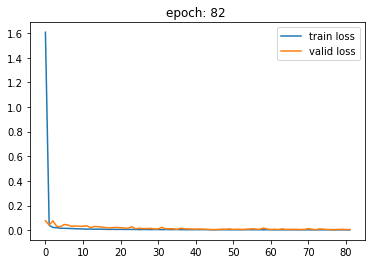

Valid Steps: 1/5  Loss: 0.0085 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-161pvglb'


Valid Steps: 5/5  Loss: 0.0085 
--------------------------------------------------
Epoch: 83  Train Loss: 0.0026  Valid Loss: 0.0085
--------------------------------------------------


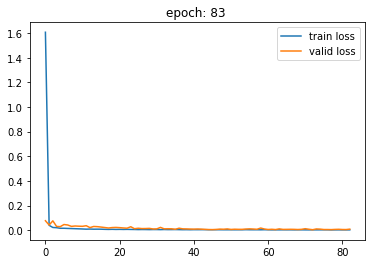

Valid Steps: 5/5  Loss: 0.0046 
--------------------------------------------------
Epoch: 84  Train Loss: 0.0027  Valid Loss: 0.0046
--------------------------------------------------


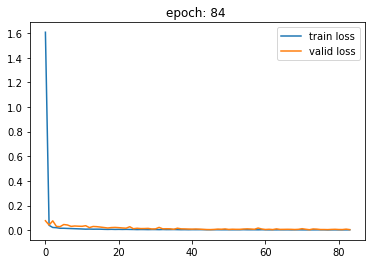

Valid Steps: 5/5  Loss: 0.0063 
--------------------------------------------------
Epoch: 85  Train Loss: 0.0026  Valid Loss: 0.0063
--------------------------------------------------


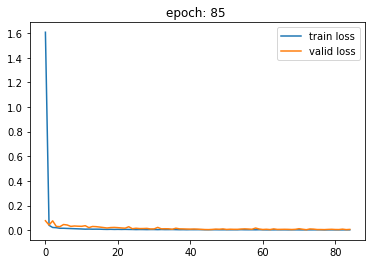

Valid Steps: 5/5  Loss: 0.0068 
--------------------------------------------------
Epoch: 86  Train Loss: 0.0027  Valid Loss: 0.0068
--------------------------------------------------


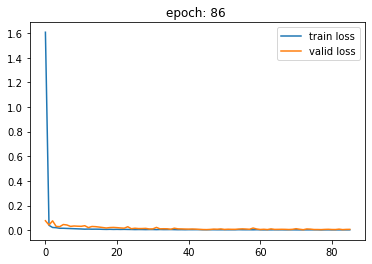

Valid Steps: 5/5  Loss: 0.0065 
--------------------------------------------------
Epoch: 87  Train Loss: 0.0024  Valid Loss: 0.0065
--------------------------------------------------


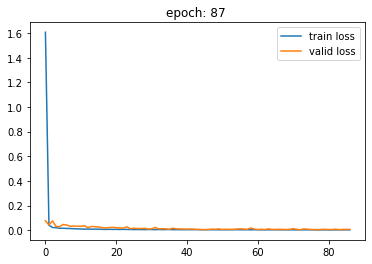

Valid Steps: 5/5  Loss: 0.0129 
--------------------------------------------------
Epoch: 88  Train Loss: 0.0029  Valid Loss: 0.0129
--------------------------------------------------


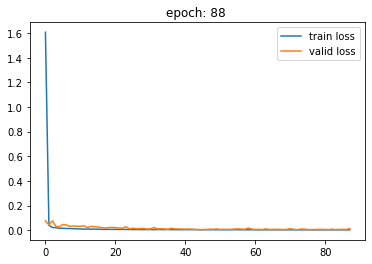

Valid Steps: 5/5  Loss: 0.0053 
--------------------------------------------------
Epoch: 89  Train Loss: 0.0025  Valid Loss: 0.0053
--------------------------------------------------


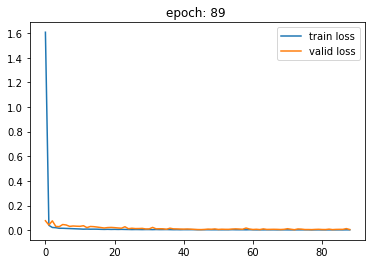

Valid Steps: 5/5  Loss: 0.0052 
--------------------------------------------------
Epoch: 90  Train Loss: 0.0025  Valid Loss: 0.0052
--------------------------------------------------


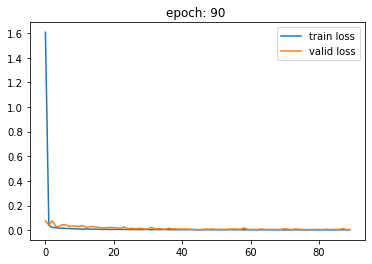

Valid Steps: 5/5  Loss: 0.0057 
--------------------------------------------------
Epoch: 91  Train Loss: 0.0023  Valid Loss: 0.0057
--------------------------------------------------


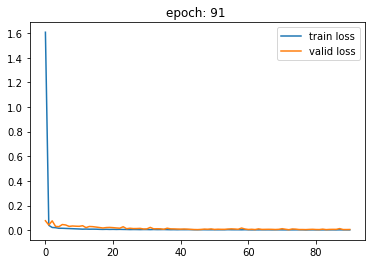

Valid Steps: 5/5  Loss: 0.0096 
--------------------------------------------------
Epoch: 92  Train Loss: 0.0022  Valid Loss: 0.0096
--------------------------------------------------


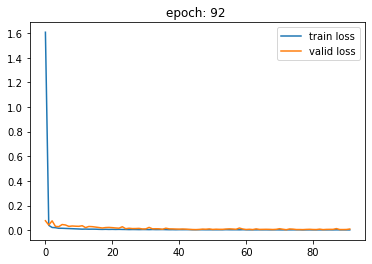

Valid Steps: 5/5  Loss: 0.0041 
--------------------------------------------------
Epoch: 93  Train Loss: 0.0022  Valid Loss: 0.0041
--------------------------------------------------


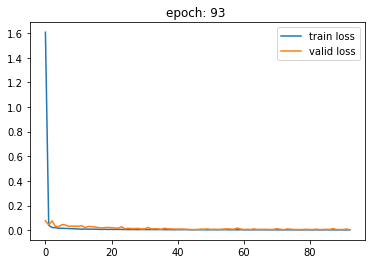

Valid Steps: 5/5  Loss: 0.0081 
--------------------------------------------------
Epoch: 94  Train Loss: 0.0027  Valid Loss: 0.0081
--------------------------------------------------


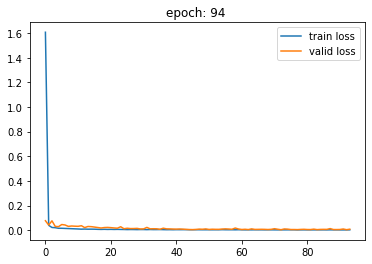

Valid Steps: 5/5  Loss: 0.0084 
--------------------------------------------------
Epoch: 95  Train Loss: 0.0023  Valid Loss: 0.0084
--------------------------------------------------


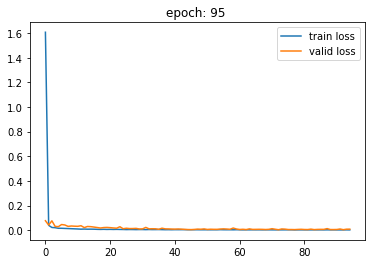

Valid Steps: 5/5  Loss: 0.0084 
--------------------------------------------------
Epoch: 96  Train Loss: 0.0025  Valid Loss: 0.0084
--------------------------------------------------


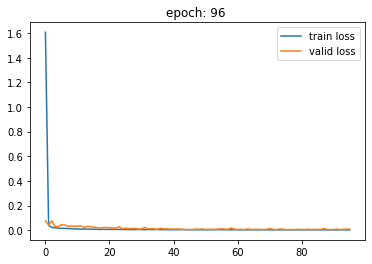

Train Steps: 3/53  Loss: 0.0022 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-cct2fkbm'


Valid Steps: 5/5  Loss: 0.0056 
--------------------------------------------------
Epoch: 97  Train Loss: 0.0021  Valid Loss: 0.0056
--------------------------------------------------


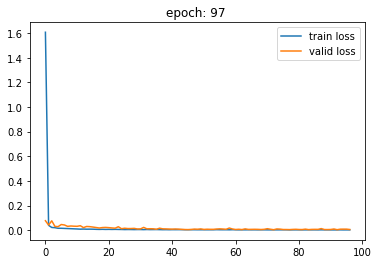

Valid Steps: 5/5  Loss: 0.0113 
--------------------------------------------------
Epoch: 98  Train Loss: 0.0021  Valid Loss: 0.0113
--------------------------------------------------


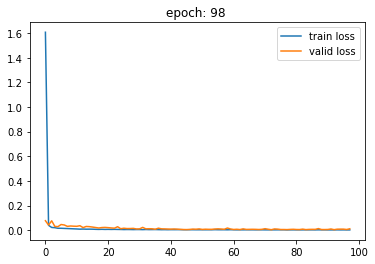

Valid Steps: 5/5  Loss: 0.0052 
--------------------------------------------------
Epoch: 99  Train Loss: 0.0022  Valid Loss: 0.0052
--------------------------------------------------


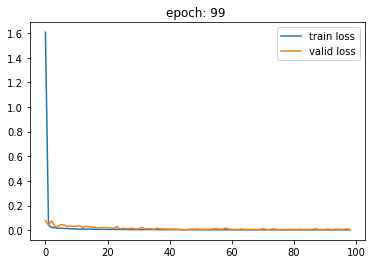

Valid Steps: 5/5  Loss: 0.0038 
--------------------------------------------------
Epoch: 100  Train Loss: 0.0019  Valid Loss: 0.0038
--------------------------------------------------


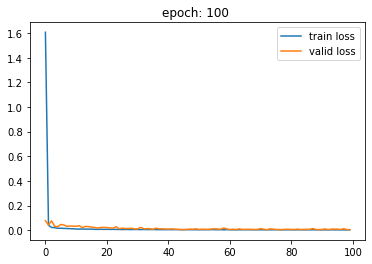


Minimum Validation Loss of 0.0038 at epoch 100/200
Model Saved

Train Steps: 2/53  Loss: 0.0014 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u47cf5gg'


Valid Steps: 5/5  Loss: 0.0068 
--------------------------------------------------
Epoch: 101  Train Loss: 0.0021  Valid Loss: 0.0068
--------------------------------------------------


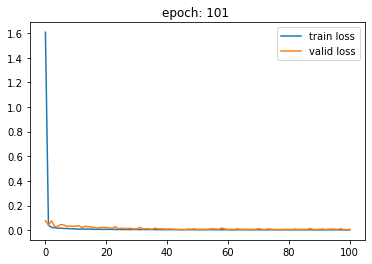

Valid Steps: 5/5  Loss: 0.0063 
--------------------------------------------------
Epoch: 102  Train Loss: 0.0019  Valid Loss: 0.0063
--------------------------------------------------


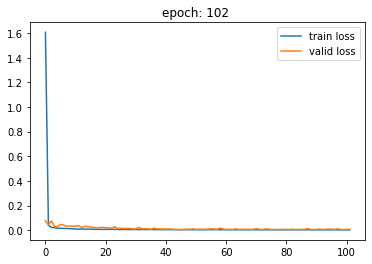

Valid Steps: 5/5  Loss: 0.0041 
--------------------------------------------------
Epoch: 103  Train Loss: 0.0019  Valid Loss: 0.0041
--------------------------------------------------


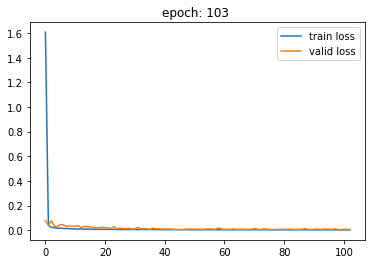

Valid Steps: 5/5  Loss: 0.0062 
--------------------------------------------------
Epoch: 104  Train Loss: 0.0017  Valid Loss: 0.0062
--------------------------------------------------


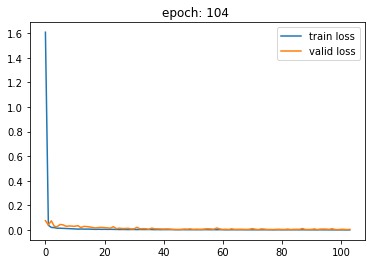

Valid Steps: 5/5  Loss: 0.0056 
--------------------------------------------------
Epoch: 105  Train Loss: 0.0020  Valid Loss: 0.0056
--------------------------------------------------


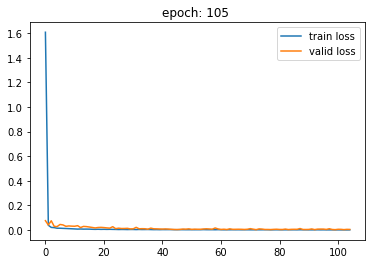

Valid Steps: 5/5  Loss: 0.0063 
--------------------------------------------------
Epoch: 106  Train Loss: 0.0019  Valid Loss: 0.0063
--------------------------------------------------


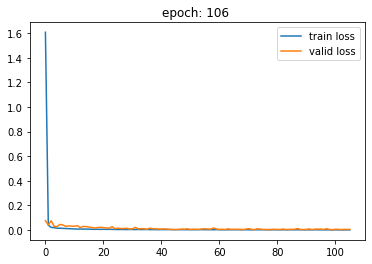

Valid Steps: 5/5  Loss: 0.0057 
--------------------------------------------------
Epoch: 107  Train Loss: 0.0019  Valid Loss: 0.0057
--------------------------------------------------


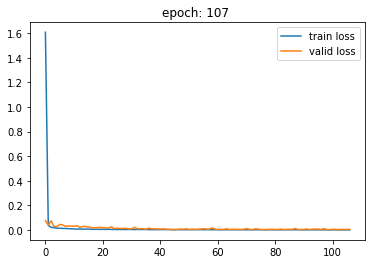

Valid Steps: 5/5  Loss: 0.0065 
--------------------------------------------------
Epoch: 108  Train Loss: 0.0019  Valid Loss: 0.0065
--------------------------------------------------


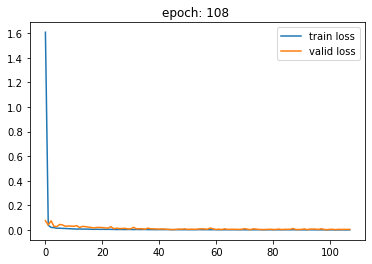

Valid Steps: 5/5  Loss: 0.0069 
--------------------------------------------------
Epoch: 109  Train Loss: 0.0017  Valid Loss: 0.0069
--------------------------------------------------


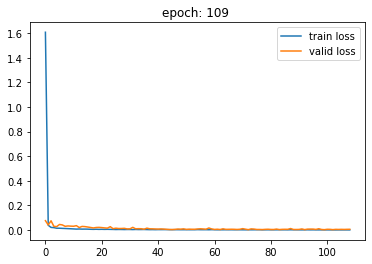

Valid Steps: 5/5  Loss: 0.0076 
--------------------------------------------------
Epoch: 110  Train Loss: 0.0018  Valid Loss: 0.0076
--------------------------------------------------


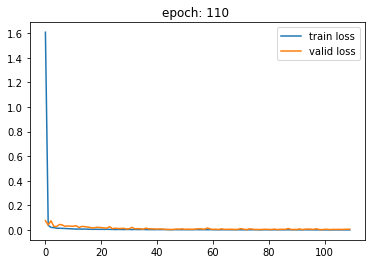

Valid Steps: 5/5  Loss: 0.0039 
--------------------------------------------------
Epoch: 111  Train Loss: 0.0016  Valid Loss: 0.0039
--------------------------------------------------


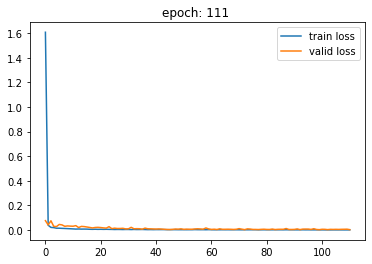

Valid Steps: 5/5  Loss: 0.0038 
--------------------------------------------------
Epoch: 112  Train Loss: 0.0017  Valid Loss: 0.0038
--------------------------------------------------


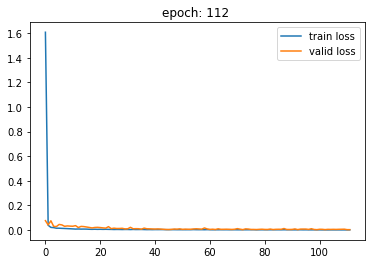


Minimum Validation Loss of 0.0038 at epoch 112/200
Model Saved

Valid Steps: 5/5  Loss: 0.0041 
--------------------------------------------------
Epoch: 113  Train Loss: 0.0016  Valid Loss: 0.0041
--------------------------------------------------


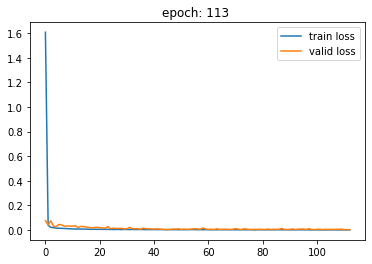

Valid Steps: 5/5  Loss: 0.0056 
--------------------------------------------------
Epoch: 114  Train Loss: 0.0017  Valid Loss: 0.0056
--------------------------------------------------


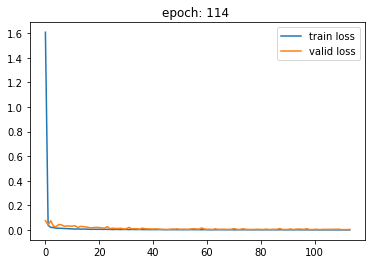

Valid Steps: 5/5  Loss: 0.0070 
--------------------------------------------------
Epoch: 115  Train Loss: 0.0017  Valid Loss: 0.0070
--------------------------------------------------


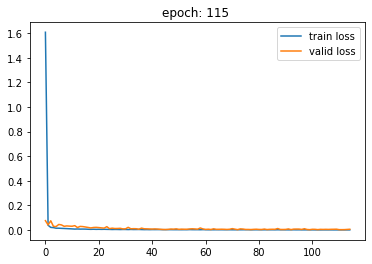

Valid Steps: 5/5  Loss: 0.0044 
--------------------------------------------------
Epoch: 116  Train Loss: 0.0015  Valid Loss: 0.0044
--------------------------------------------------


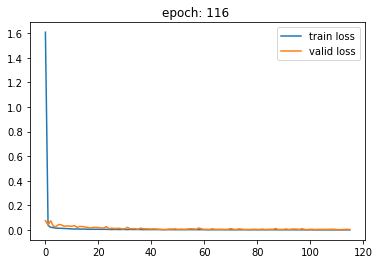

Valid Steps: 5/5  Loss: 0.0041 
--------------------------------------------------
Epoch: 117  Train Loss: 0.0016  Valid Loss: 0.0041
--------------------------------------------------


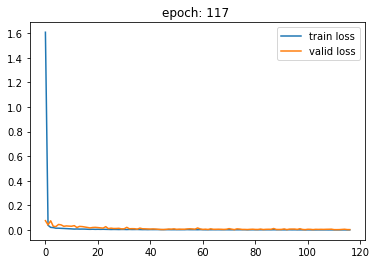

Train Steps: 28/53  Loss: 0.0017 

KeyboardInterrupt: ignored

In [ ]:
start_time = time.time()
loss_train_list =[]
loss_valid_list=[]
train_init_land = torch.tensor([]).type(torch.cuda.FloatTensor)

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    Network().train()
    gcn.train()
    gin_local.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks, init_land = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.reshape(landmarks.shape[0],-1).cuda()
        init_land = init_land.cuda()

        if step == 1:
          train_init_land = torch.cat([train_init_land,init_land])
        
        global_t, prediction = gcn(images,init_land) #(batch_size,9) / extracted feature map
        pt_land = make_perspective_transform(global_t, init_land)
        pt_land_for_loss = pt_land.reshape(pt_land.shape[0],-1)

        outputs = gin_local(prediction, pt_land)
        outputs = outputs.reshape(outputs.shape[0],-1)

        # find the loss for the current step
        loss_global = criterion(pt_land_for_loss, landmarks)
        optimizer_global.zero_grad()
        loss_local = criterion(outputs, landmarks)
        optimizer_local.zero_grad()
        
        # calculate the gradients
        loss_global.backward(retain_graph=True)
        loss_local.backward(inputs=list(gin_local.parameters()))
        
        # update the parameters
        optimizer_global.step()
        optimizer_local.step()
        
        loss_train_step = loss_global + loss_local
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    Network().eval()
    gcn.eval()
    gin_local.eval()
    with torch.no_grad():
        for step in range(1,len(valid_loader)+1):

          images_valid, landmarks_valid = next(iter(valid_loader))
      
          images_valid = images_valid.cuda()
          landmarks_valid = landmarks_valid.reshape(landmarks_valid.shape[0],-1).cuda()
          til = train_init_land[0].repeat(images_valid.shape[0],1,1)
          til = til.cuda()
      
          global_t, prediction = gcn(images_valid, til) #(batch_size,9) / extracted feature map
          pt_land = make_perspective_transform(global_t, til)

          loss_global = criterion(pt_land.reshape(pt_land.shape[0],-1), landmarks_valid)     

          outputs = gin_local(prediction, pt_land)
          outputs = outputs.reshape(outputs.shape[0],-1)
          
          # find the loss for the current step
          loss_local = criterion(outputs, landmarks)
          
          loss_valid_step = loss_global + loss_local
          loss_valid += loss_valid_step.item()
          running_loss = loss_valid/step

          print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    scheduler_global.step(loss_valid)
    scheduler_local.step(loss_valid)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_train_list.append(loss_train)
    loss_valid_list.append(loss_valid)
    plt.plot(loss_train_list,label='train loss')
    plt.plot(loss_valid_list,label='valid loss')

    plt.legend(loc='upper right')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)
    
    if loss_valid < loss_min:     
      loss_min = loss_valid
      torch.save(gcn.state_dict(), '/content/drive/MyDrive/IXIDB_axial_model_save/210517_gcn_param.pth')
      torch.save(gcn.state_dict(), '/content/drive/MyDrive/IXIDB_axial_model_save/210517_gin_local_param.pth')
      print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
      print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Total number of test images: 37
Elapsed Time : 1.01888108253479


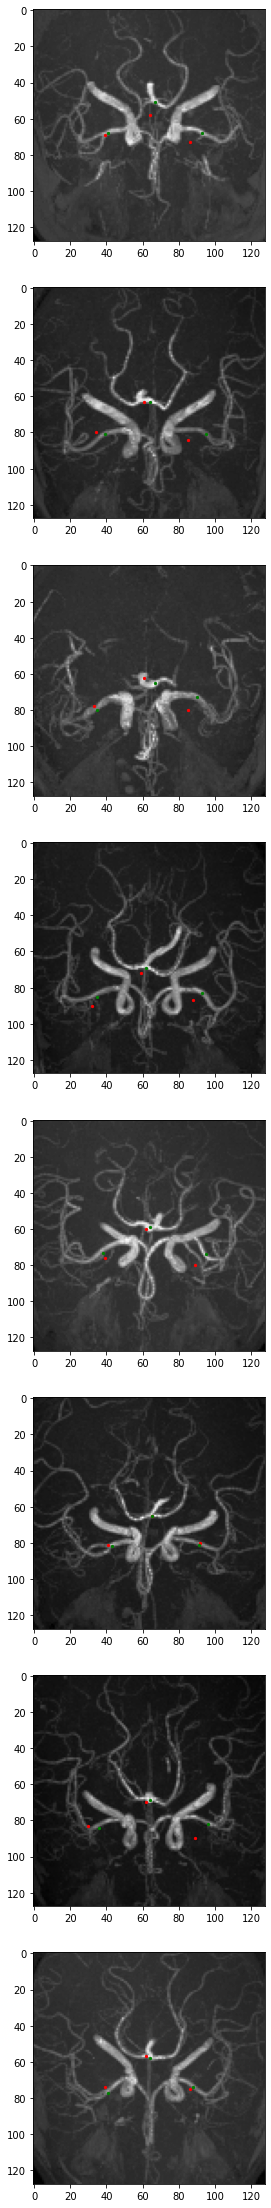

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    gin_local.cuda()
    gcn.cuda()
    #best_network.load_state_dict(torch.load('/content/drive/MyDrive/IXIDB_axial_model_save/face_landmarks.pth')) 
    best_network.eval()
    gin_local.eval()
    gcn.eval()
    
    images, landmarks = next(iter(valid_loader))
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 128
    til = train_init_land[0].repeat(images_valid.shape[0],1,1)
    til = til.cuda()

    global_t, prediction = gcn(images_valid, til) #(batch_size,9) / extracted feature map
    pt_land = make_perspective_transform(global_t, til) 

    outputs = gin_local(prediction, pt_land)
    #outputs = outputs.reshape(outputs.shape[0],-1)

    predictions = (outputs.cpu() + 0.5) * 128
    #predictions = predictions.view(-1,3,2)
    predictions = torch.round(predictions)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(dataset_valid)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 